# Load CholecGoNoGo Dataset

Minimal example to load and display examples from the CholecGoNoGo dataset (Go/NoGo regions for safe dissection).

In [1]:
import sys
sys.path.insert(0, '/shared_data0/weiqiuy/llm_cholec_organ/src')

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from endopoint.datasets import build_dataset
import numpy as np

In [2]:
# Load the CholecGoNoGo dataset
dataset = build_dataset(
    "cholec_gonogo",
    data_dir="/shared_data0/weiqiuy/real_drs/data/abdomen_exlib",
    video_globs='public',  # Can be 'public' or 'private'
    train_ratio=0.8,
    gen_seed=56,  # Default seed for train/test split
    train_val_seed=0,  # Default seed for train/val split
    image_height=384,
    image_width=640
)

print(f"Dataset: {dataset.dataset_tag}")
print(f"Version: {dataset.version}")
print(f"Train examples: {dataset.total('train')}")
print(f"Validation examples: {dataset.total('validation')}")
print(f"Test examples: {dataset.total('test')}")
print(f"\nGoNoGo classes: {dataset.id2label}")
print(f"Target image size: {dataset.recommended_canvas}")

Indexing training videos...


  Train videos: 100%|██████████| 96/96 [00:00<00:00, 539.49it/s]


Indexing test videos...


  Test videos: 100%|██████████| 25/25 [00:00<00:00, 537.37it/s]


Building examples list...


  Checking files: 100%|██████████| 1015/1015 [00:00<00:00, 36273.63it/s]

CholecGoNoGo dataset indexed:
  Total examples: 1015
  Train: 716 examples
  Validation: 80 examples
  Test: 219 examples
Dataset: cholec_gonogo
Version: local
Train examples: 716
Validation examples: 80
Test examples: 219

GoNoGo classes: {0: 'Background', 1: 'Go', 2: 'NoGo'}
Target image size: (384, 640)


## Load and Display a Single Example

In [3]:
# Load a single example from training set
example_idx = 0
example = dataset.get_example("train", example_idx)

image = example['image']  # PIL Image
gonogo_label = example['gonogo_label']  # PIL Image with Go/NoGo labels
filename = example['filename']

print(f"Filename: {filename}")
print(f"Image size: {image.size}")
print(f"Label size: {gonogo_label.size}")

Filename: M2CCAI2016_video88_003.png
Image size: (640, 384)
Label size: (640, 384)


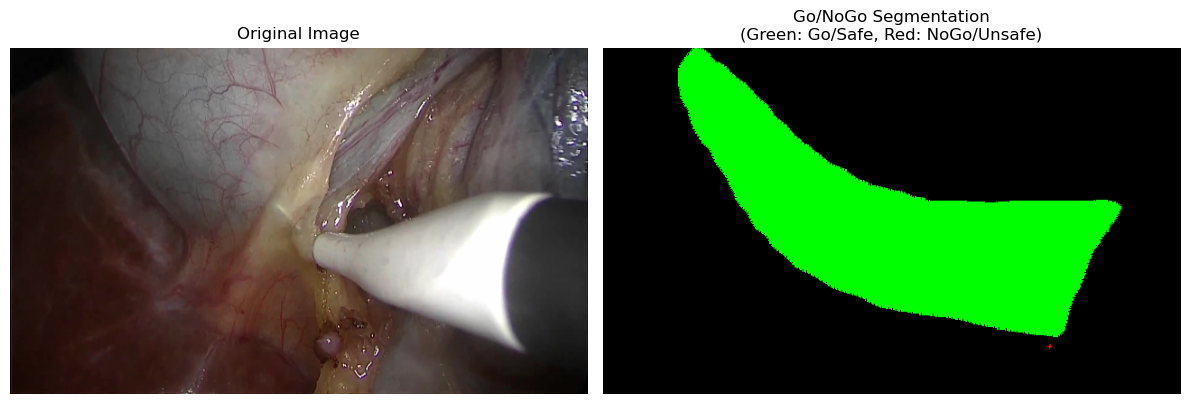

In [4]:
# Display the image and Go/NoGo segmentation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Convert label to numpy for visualization
label_np = np.array(gonogo_label)

# Create a colored visualization of the labels
# 0: Background (black), 1: Go (green - safe), 2: NoGo (red - unsafe)
colored_label = np.zeros((*label_np.shape, 3), dtype=np.uint8)
colored_label[label_np == 1] = [0, 255, 0]     # Go - green (safe to dissect)
colored_label[label_np == 2] = [255, 0, 0]     # NoGo - red (unsafe to dissect)

axes[1].imshow(colored_label)
axes[1].set_title('Go/NoGo Segmentation\n(Green: Go/Safe, Red: NoGo/Unsafe)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Convert to Tensors and Check Region Presence

In [5]:
# Convert to tensors
img_tensor, label_tensor = dataset.example_to_tensors(example)
print(f"Image tensor shape: {img_tensor.shape} (C, H, W)")
print(f"Label tensor shape: {label_tensor.shape} (H, W)")
print(f"Unique label values: {label_tensor.unique().tolist()}")

# Get presence vector
presence = dataset.labels_to_presence_vector(label_tensor, min_pixels=50)
print(f"\nPresence vector: {presence.tolist()}")
print(f"  Go region present: {'Yes' if presence[0] == 1 else 'No'}")
print(f"  NoGo region present: {'Yes' if presence[1] == 1 else 'No'}")

print("\nRegions present in this image:")
for i, class_id in enumerate(dataset.label_ids):
    if presence[i] == 1:
        region_name = dataset.id2label[class_id]
        point = dataset.sample_point_in_mask(label_tensor, class_id, strategy="centroid")
        print(f"  - {region_name} region at centroid {point}")

Image tensor shape: torch.Size([3, 384, 640]) (C, H, W)
Label tensor shape: torch.Size([384, 640]) (H, W)
Unique label values: [0, 1, 2]

Presence vector: [1, 0]
  Go region present: Yes
  NoGo region present: No

Regions present in this image:
  - Go region at centroid (321, 194)


## Get Bounding Boxes for Go/NoGo Regions

In [6]:
# Get bounding boxes for Go/NoGo regions
bboxes = dataset.get_bounding_boxes(label_tensor, min_pixels=50)

print("Bounding boxes by region type:")
for class_id, boxes in bboxes.items():
    region_name = dataset.id2label[class_id]
    print(f"\n{region_name}: {len(boxes)} region(s)")
    for i, bbox in enumerate(boxes):
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min + 1
        height = y_max - y_min + 1
        area = (label_tensor == class_id).sum().item()
        print(f"  Region {i+1}: ({x_min}, {y_min}) to ({x_max}, {y_max})")
        print(f"    Size: {width}x{height}, Total area: {area} pixels")

Bounding boxes by region type:

Go: 1 region(s)
  Region 1: (83, 0) to (573, 320)
    Size: 491x321, Total area: 60827 pixels


In [7]:
# Get bounding boxes with labels (more convenient format)
bbox_list = dataset.get_bounding_boxes_with_labels(label_tensor)

print(f"Total bounding boxes: {len(bbox_list)}")
for box_info in bbox_list:
    print(f"  {box_info['class_name']}: bbox={box_info['bbox']}, area={box_info['area']} pixels")

Total bounding boxes: 2
  Go: bbox=(83, 0, 573, 320), area=60810 pixels
  NoGo: bbox=(492, 329, 496, 333), area=12 pixels


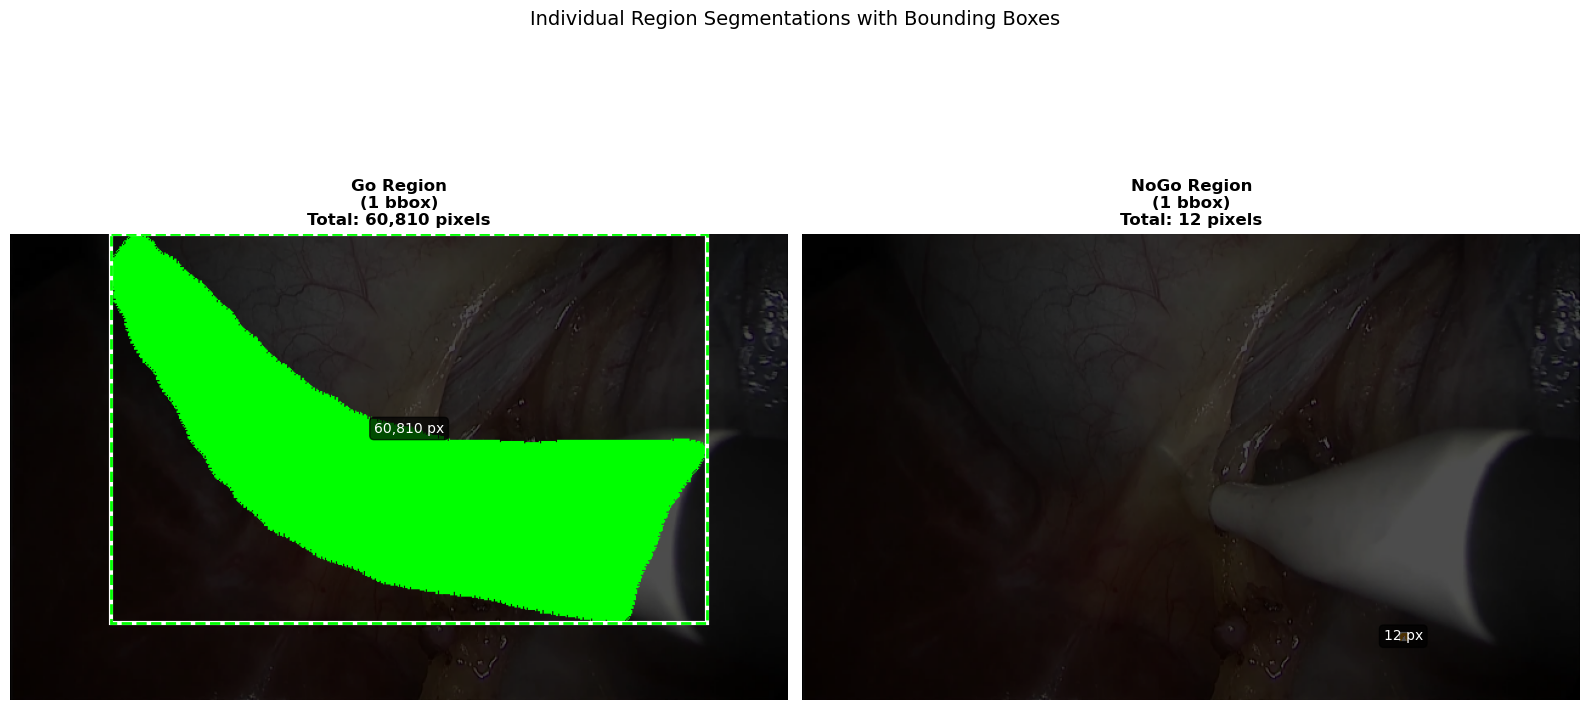

In [8]:
# Visualize each region's segmentation with its bounding boxes separately
import numpy as np
from collections import defaultdict

# Group bounding boxes by region class
region_bboxes = defaultdict(list)
for box_info in bbox_list:
    region_bboxes[box_info['class_id']].append(box_info)

# Create subplots for each region type present
n_regions = len(region_bboxes)
if n_regions > 0:
    fig, axes = plt.subplots(1, n_regions, figsize=(8 * n_regions, 8))
    if n_regions == 1:
        axes = [axes]
    
    # Process each region type
    label_array = np.array(label_tensor)
    
    for idx, (class_id, bboxes) in enumerate(region_bboxes.items()):
        ax = axes[idx]
        
        # Create a background (dimmed original image)
        background = np.array(image) * 0.3  # Dim the original image
        background = background.astype(np.uint8)
        
        # Create mask for this region type
        region_mask = (label_array == class_id)
        
        # Create visualization with region highlighted
        vis_image = background.copy()
        
        # Apply region coloring
        if class_id == 1:  # Go region - green
            vis_image[region_mask] = [0, 255, 0]
        elif class_id == 2:  # NoGo region - red
            vis_image[region_mask] = [255, 0, 0]
        
        # Display the image
        ax.imshow(vis_image)
        
        # Draw all bounding boxes for this region
        for box_info in bboxes:
            x_min, y_min, x_max, y_max = box_info['bbox']
            width = x_max - x_min
            height = y_max - y_min
            
            # Draw bounding box with white border
            rect = patches.Rectangle((x_min, y_min), width, height,
                                    linewidth=3, edgecolor='white', facecolor='none')
            ax.add_patch(rect)
            
            # Draw inner colored rectangle for contrast
            color = 'lime' if class_id == 1 else 'orange'
            rect_inner = patches.Rectangle((x_min, y_min), width, height,
                                          linewidth=2, edgecolor=color, facecolor='none', linestyle='--')
            ax.add_patch(rect_inner)
            
            # Add area annotation
            ax.text(x_min + width/2, y_min + height/2, f"{box_info['area']:,} px",
                   color='white', fontsize=10, ha='center', va='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))
        
        # Set title with region name and bbox count
        region_name = dataset.id2label[class_id]
        total_area = sum(b['area'] for b in bboxes)
        ax.set_title(f'{region_name} Region\n({len(bboxes)} bbox{"es" if len(bboxes) > 1 else ""})\nTotal: {total_area:,} pixels', 
                    fontsize=12, weight='bold')
        ax.axis('off')
    
    plt.suptitle('Individual Region Segmentations with Bounding Boxes', fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()
else:
    print("No regions detected in this image with minimum pixel threshold.")

In [9]:
# Analyze bounding box statistics across a sample of the dataset
from tqdm import tqdm

print("Analyzing bounding box statistics...")
sample_size = min(100, dataset.total('train'))
sample_indices = np.random.choice(dataset.total('train'), sample_size, replace=False)

bbox_stats = {
    'Go': {'counts': [], 'areas': [], 'widths': [], 'heights': []},
    'NoGo': {'counts': [], 'areas': [], 'widths': [], 'heights': []}
}

# Collect statistics
for idx in tqdm(sample_indices, desc="Processing samples"):
    example = dataset.get_example('train', int(idx))
    img_t, lab_t = dataset.example_to_tensors(example)
    bbox_list = dataset.get_bounding_boxes_with_labels(lab_t, min_pixels=50)
    
    # Group by region type
    go_bboxes = [b for b in bbox_list if b['class_id'] == 1]
    nogo_bboxes = [b for b in bbox_list if b['class_id'] == 2]
    
    # Go statistics
    if go_bboxes:
        bbox_stats['Go']['counts'].append(len(go_bboxes))
        for box in go_bboxes:
            x1, y1, x2, y2 = box['bbox']
            width = x2 - x1 + 1
            height = y2 - y1 + 1
            bbox_stats['Go']['areas'].append(box['area'])
            bbox_stats['Go']['widths'].append(width)
            bbox_stats['Go']['heights'].append(height)
    
    # NoGo statistics
    if nogo_bboxes:
        bbox_stats['NoGo']['counts'].append(len(nogo_bboxes))
        for box in nogo_bboxes:
            x1, y1, x2, y2 = box['bbox']
            width = x2 - x1 + 1
            height = y2 - y1 + 1
            bbox_stats['NoGo']['areas'].append(box['area'])
            bbox_stats['NoGo']['widths'].append(width)
            bbox_stats['NoGo']['heights'].append(height)

# Print statistics
print(f"\n📊 Bounding Box Statistics (from {sample_size} samples):")
print("=" * 60)

for region_type in ['Go', 'NoGo']:
    stats = bbox_stats[region_type]
    if stats['counts']:
        print(f"\n{region_type} Region:")
        print(f"  Images with {region_type}: {len(stats['counts'])} / {sample_size} ({100*len(stats['counts'])/sample_size:.1f}%)")
        print(f"  Bboxes per image: {np.mean(stats['counts']):.2f} ± {np.std(stats['counts']):.2f}")
        print(f"  Total bboxes: {sum(stats['counts'])}")
        
        if stats['areas']:
            print(f"  Area (pixels): {np.mean(stats['areas']):.0f} ± {np.std(stats['areas']):.0f}")
            print(f"    Min: {np.min(stats['areas']):.0f}, Max: {np.max(stats['areas']):.0f}")
            print(f"  Width (pixels): {np.mean(stats['widths']):.0f} ± {np.std(stats['widths']):.0f}")
            print(f"  Height (pixels): {np.mean(stats['heights']):.0f} ± {np.std(stats['heights']):.0f}")
    else:
        print(f"\n{region_type} Region: Not found in sampled images")

Analyzing bounding box statistics...


Processing samples: 100%|██████████| 100/100 [00:01<00:00, 50.36it/s]


📊 Bounding Box Statistics (from 100 samples):

Go Region:
  Images with Go: 92 / 100 (92.0%)
  Bboxes per image: 1.00 ± 0.00
  Total bboxes: 92
  Area (pixels): 20138 ± 10135
    Min: 2608, Max: 52534
  Width (pixels): 199 ± 83
  Height (pixels): 203 ± 65

NoGo Region:
  Images with NoGo: 92 / 100 (92.0%)
  Bboxes per image: 1.17 ± 0.41
  Total bboxes: 108
  Area (pixels): 28604 ± 22135
    Min: 1140, Max: 119410
  Width (pixels): 288 ± 151
  Height (pixels): 164 ± 80


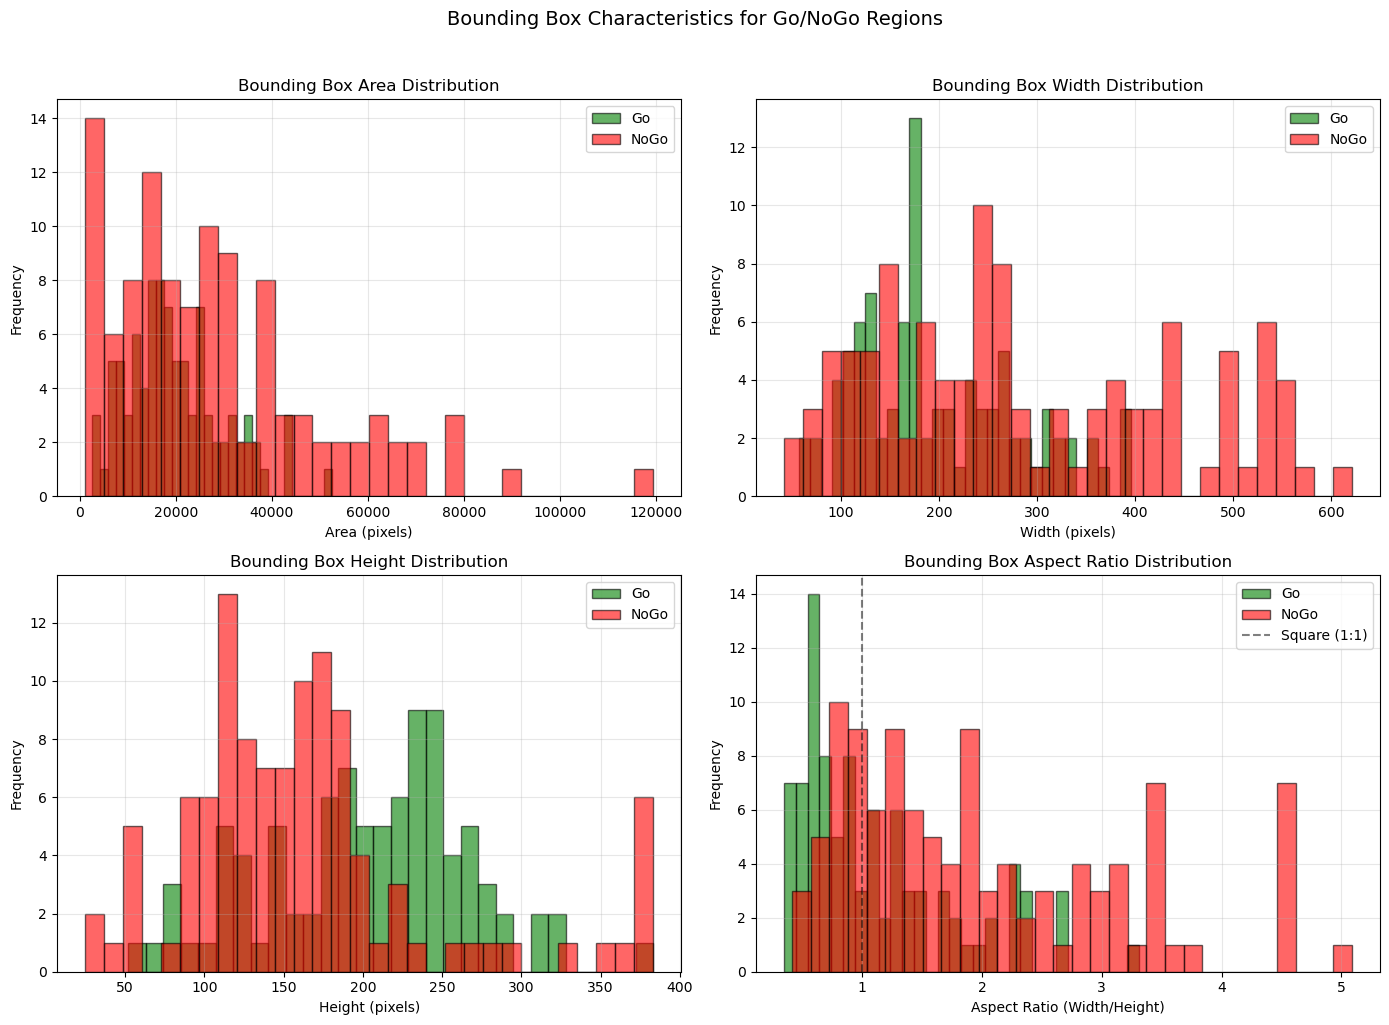

In [10]:
# Visualize bounding box size distributions
if any(bbox_stats[rt]['areas'] for rt in ['Go', 'NoGo']):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot area distributions
    ax = axes[0, 0]
    for region_type, color in [('Go', 'green'), ('NoGo', 'red')]:
        if bbox_stats[region_type]['areas']:
            ax.hist(bbox_stats[region_type]['areas'], bins=30, alpha=0.6, 
                   color=color, label=region_type, edgecolor='black')
    ax.set_xlabel('Area (pixels)')
    ax.set_ylabel('Frequency')
    ax.set_title('Bounding Box Area Distribution')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Plot width distributions
    ax = axes[0, 1]
    for region_type, color in [('Go', 'green'), ('NoGo', 'red')]:
        if bbox_stats[region_type]['widths']:
            ax.hist(bbox_stats[region_type]['widths'], bins=30, alpha=0.6,
                   color=color, label=region_type, edgecolor='black')
    ax.set_xlabel('Width (pixels)')
    ax.set_ylabel('Frequency')
    ax.set_title('Bounding Box Width Distribution')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Plot height distributions
    ax = axes[1, 0]
    for region_type, color in [('Go', 'green'), ('NoGo', 'red')]:
        if bbox_stats[region_type]['heights']:
            ax.hist(bbox_stats[region_type]['heights'], bins=30, alpha=0.6,
                   color=color, label=region_type, edgecolor='black')
    ax.set_xlabel('Height (pixels)')
    ax.set_ylabel('Frequency')
    ax.set_title('Bounding Box Height Distribution')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Plot aspect ratio (width/height)
    ax = axes[1, 1]
    for region_type, color in [('Go', 'green'), ('NoGo', 'red')]:
        if bbox_stats[region_type]['widths'] and bbox_stats[region_type]['heights']:
            aspect_ratios = np.array(bbox_stats[region_type]['widths']) / np.array(bbox_stats[region_type]['heights'])
            ax.hist(aspect_ratios, bins=30, alpha=0.6,
                   color=color, label=region_type, edgecolor='black')
    ax.set_xlabel('Aspect Ratio (Width/Height)')
    ax.set_ylabel('Frequency')
    ax.set_title('Bounding Box Aspect Ratio Distribution')
    ax.axvline(x=1, color='black', linestyle='--', alpha=0.5, label='Square (1:1)')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.suptitle('Bounding Box Characteristics for Go/NoGo Regions', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

Finding examples with multiple disconnected regions...
Found 4 examples with multiple disconnected regions


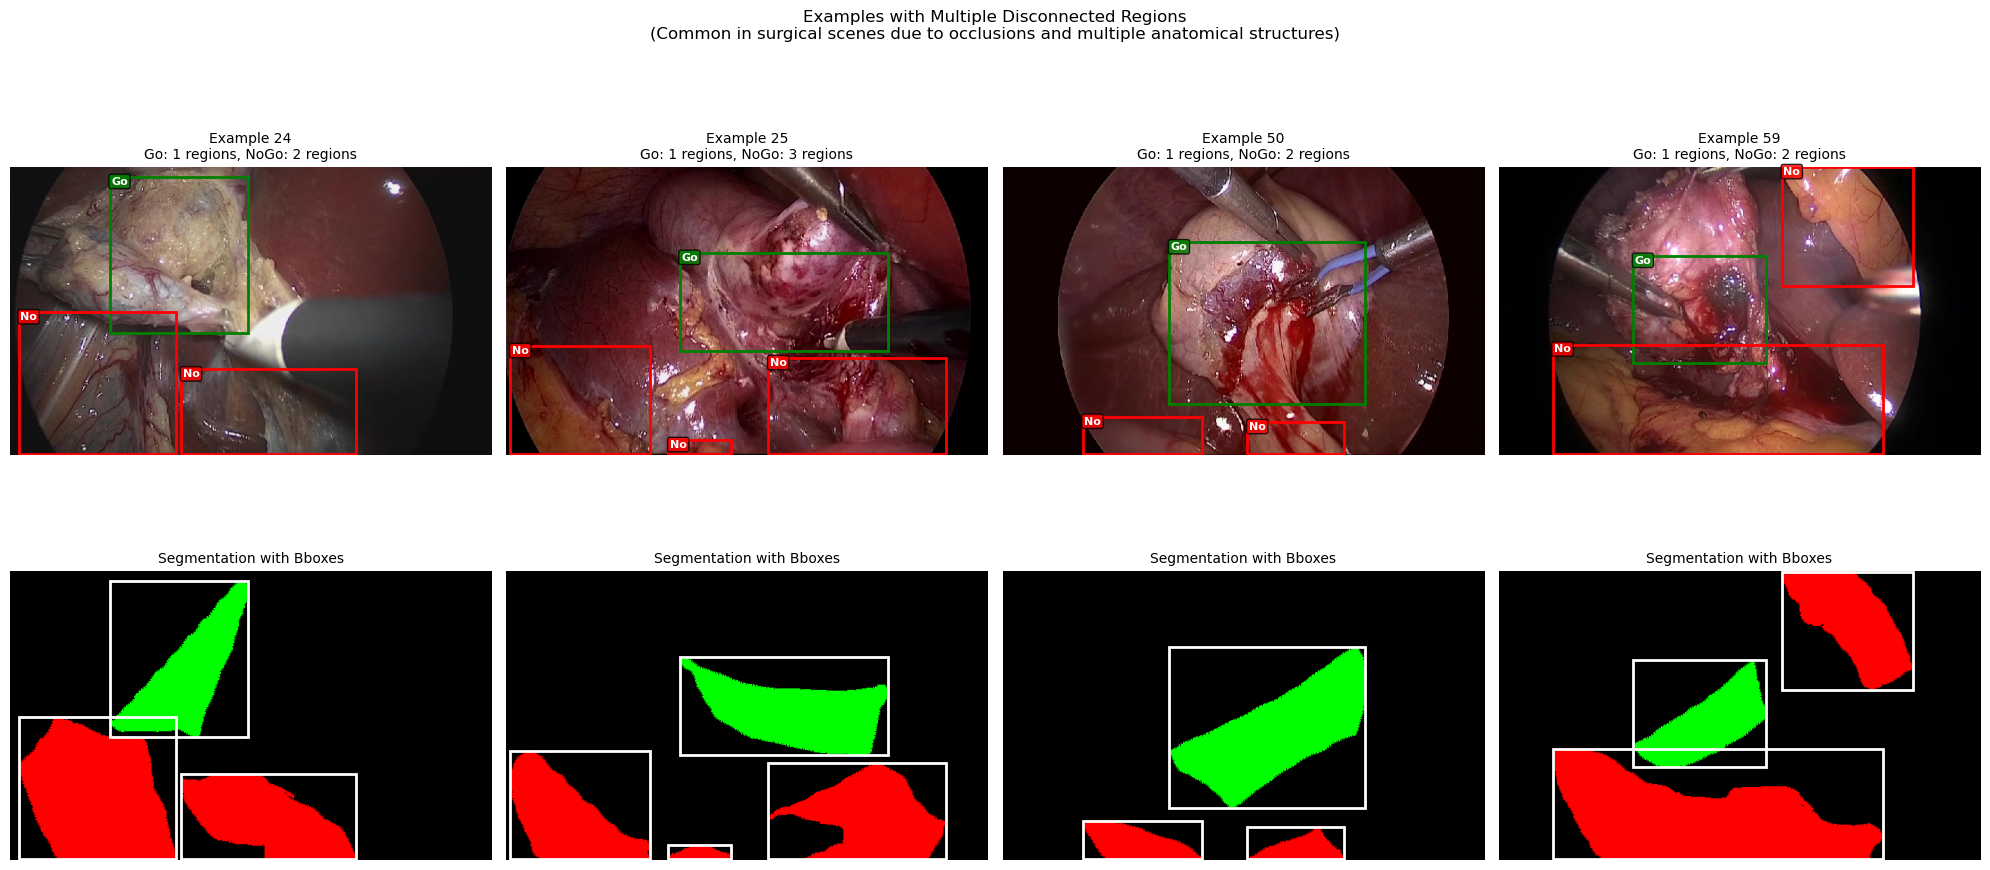

In [11]:
# Find examples with multiple disconnected regions
print("Finding examples with multiple disconnected regions...")

multi_region_examples = []
for idx in range(min(200, dataset.total('train'))):
    example = dataset.get_example('train', idx)
    img_t, lab_t = dataset.example_to_tensors(example)
    bbox_list = dataset.get_bounding_boxes_with_labels(lab_t, min_pixels=50)
    
    # Count bboxes per region type
    go_count = sum(1 for b in bbox_list if b['class_id'] == 1)
    nogo_count = sum(1 for b in bbox_list if b['class_id'] == 2)
    
    # Look for examples with multiple disconnected regions
    if go_count > 1 or nogo_count > 1:
        multi_region_examples.append({
            'idx': idx,
            'go_count': go_count,
            'nogo_count': nogo_count,
            'total_count': len(bbox_list)
        })
        
        if len(multi_region_examples) >= 4:
            break

if multi_region_examples:
    print(f"Found {len(multi_region_examples)} examples with multiple disconnected regions")
    
    # Visualize them
    n_show = min(4, len(multi_region_examples))
    fig, axes = plt.subplots(2, n_show, figsize=(5 * n_show, 10))
    if n_show == 1:
        axes = axes.reshape(-1, 1)
    
    for col, example_info in enumerate(multi_region_examples[:n_show]):
        idx = example_info['idx']
        example = dataset.get_example('train', idx)
        img_t, lab_t = dataset.example_to_tensors(example)
        bbox_list = dataset.get_bounding_boxes_with_labels(lab_t, min_pixels=50)
        
        # Top row: Original image with all bounding boxes
        ax = axes[0, col]
        ax.imshow(example['image'])
        
        # Draw all bounding boxes
        for box_info in bbox_list:
            x_min, y_min, x_max, y_max = box_info['bbox']
            width = x_max - x_min
            height = y_max - y_min
            
            color = 'green' if box_info['class_id'] == 1 else 'red'
            rect = patches.Rectangle((x_min, y_min), width, height,
                                    linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            
            # Add small label
            ax.text(x_min + 2, y_min + 10, box_info['class_name'][:2],
                   color='white', fontsize=8, weight='bold',
                   bbox=dict(boxstyle="round,pad=0.2", facecolor=color, alpha=0.8))
        
        ax.set_title(f"Example {idx}\nGo: {example_info['go_count']} regions, NoGo: {example_info['nogo_count']} regions",
                    fontsize=10)
        ax.axis('off')
        
        # Bottom row: Segmentation visualization
        ax = axes[1, col]
        label_np = np.array(example['gonogo_label'])
        colored_label = np.zeros((*label_np.shape, 3), dtype=np.uint8)
        colored_label[label_np == 1] = [0, 255, 0]  # Go - green
        colored_label[label_np == 2] = [255, 0, 0]  # NoGo - red
        
        ax.imshow(colored_label)
        
        # Draw bounding boxes on segmentation too
        for box_info in bbox_list:
            x_min, y_min, x_max, y_max = box_info['bbox']
            width = x_max - x_min
            height = y_max - y_min
            
            rect = patches.Rectangle((x_min, y_min), width, height,
                                    linewidth=2, edgecolor='white', facecolor='none')
            ax.add_patch(rect)
        
        ax.set_title('Segmentation with Bboxes', fontsize=10)
        ax.axis('off')
    
    plt.suptitle('Examples with Multiple Disconnected Regions\n' +
                 '(Common in surgical scenes due to occlusions and multiple anatomical structures)',
                 fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No examples with multiple disconnected regions found in the sample.")

## Examples with Multiple Disconnected Regions

## Analyze Bounding Box Statistics Across Dataset

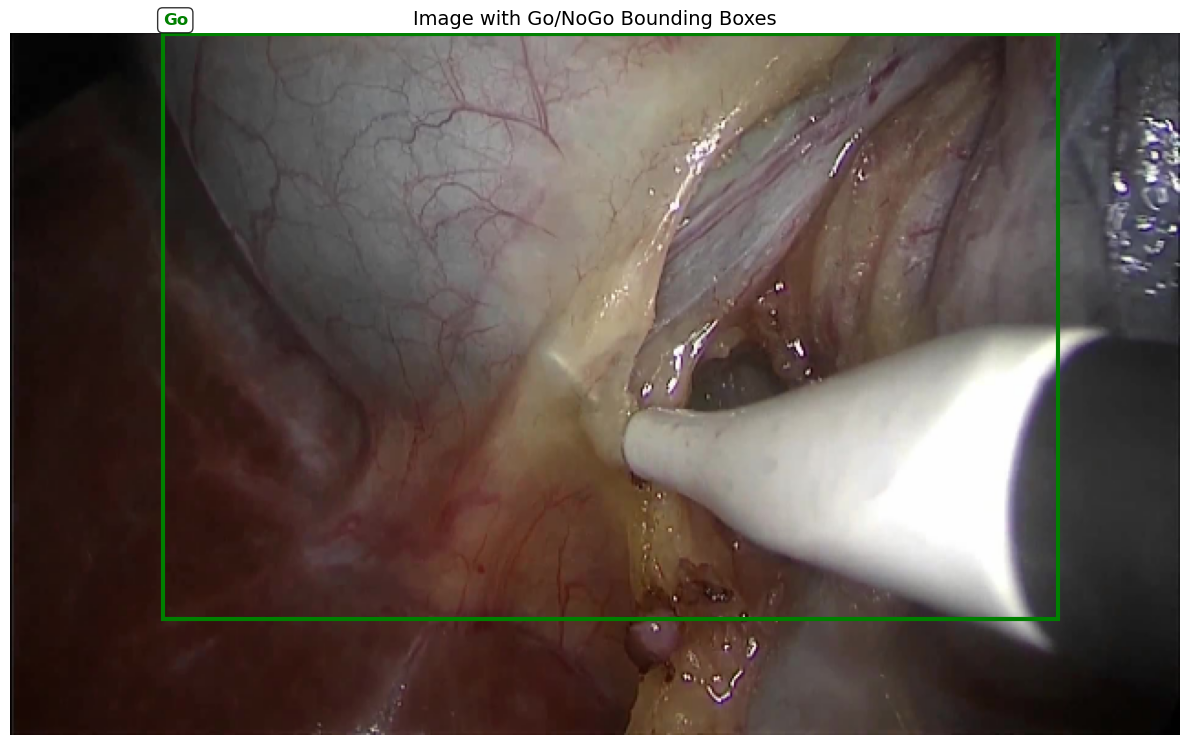

In [12]:
# Visualize bounding boxes on the image
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(image)

# Define colors for each region type
region_colors = {
    1: 'green',   # Go - safe
    2: 'red'      # NoGo - unsafe
}

# Get bounding boxes with labels (returns list of dicts)
bbox_list = dataset.get_bounding_boxes_with_labels(label_tensor, min_pixels=50)

# Draw bounding boxes
for box_info in bbox_list:
    class_id = box_info['class_id']
    region_name = box_info['class_name']
    color = region_colors.get(class_id, 'white')
    
    x_min, y_min, x_max, y_max = box_info['bbox']
    width = x_max - x_min
    height = y_max - y_min
    
    # Create rectangle patch
    rect = patches.Rectangle((x_min, y_min), width, height,
                            linewidth=3, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    
    # Add label
    ax.text(x_min, y_min - 5, region_name, 
           color=color, fontsize=12, weight='bold',
           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

ax.set_title('Image with Go/NoGo Bounding Boxes', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

## Analyze Dataset Statistics

In [13]:
# Analyze Go/NoGo distribution across splits
from collections import defaultdict
import torch

split_stats = {}

for split in ['train', 'validation', 'test']:
    print(f"\nAnalyzing {split} split ({dataset.total(split)} examples)...")
    
    region_counts = defaultdict(int)
    total_examples = dataset.total(split)
    
    # Sample a subset for faster analysis
    sample_size = min(100, total_examples)
    sample_indices = np.random.choice(total_examples, sample_size, replace=False)
    
    for idx in sample_indices:
        example = dataset.get_example(split, int(idx))
        img_t, lab_t = dataset.example_to_tensors(example)
        presence = dataset.labels_to_presence_vector(lab_t, min_pixels=50)
        
        for i, class_id in enumerate(dataset.label_ids):
            if presence[i] == 1:
                region_counts[class_id] += 1
    
    # Store and print statistics
    split_stats[split] = region_counts
    
    print(f"  Region presence in {sample_size} sampled images:")
    for class_id in dataset.label_ids:
        region_name = dataset.id2label[class_id]
        count = region_counts[class_id]
        percentage = (count / sample_size) * 100
        print(f"    {region_name:15} {count:3d} / {sample_size} ({percentage:5.1f}%)")


Analyzing train split (716 examples)...
  Region presence in 100 sampled images:
    Go               98 / 100 ( 98.0%)
    NoGo             88 / 100 ( 88.0%)

Analyzing validation split (80 examples)...
  Region presence in 80 sampled images:
    Go               72 / 80 ( 90.0%)
    NoGo             72 / 80 ( 90.0%)

Analyzing test split (219 examples)...
  Region presence in 100 sampled images:
    Go               93 / 100 ( 93.0%)
    NoGo             91 / 100 ( 91.0%)


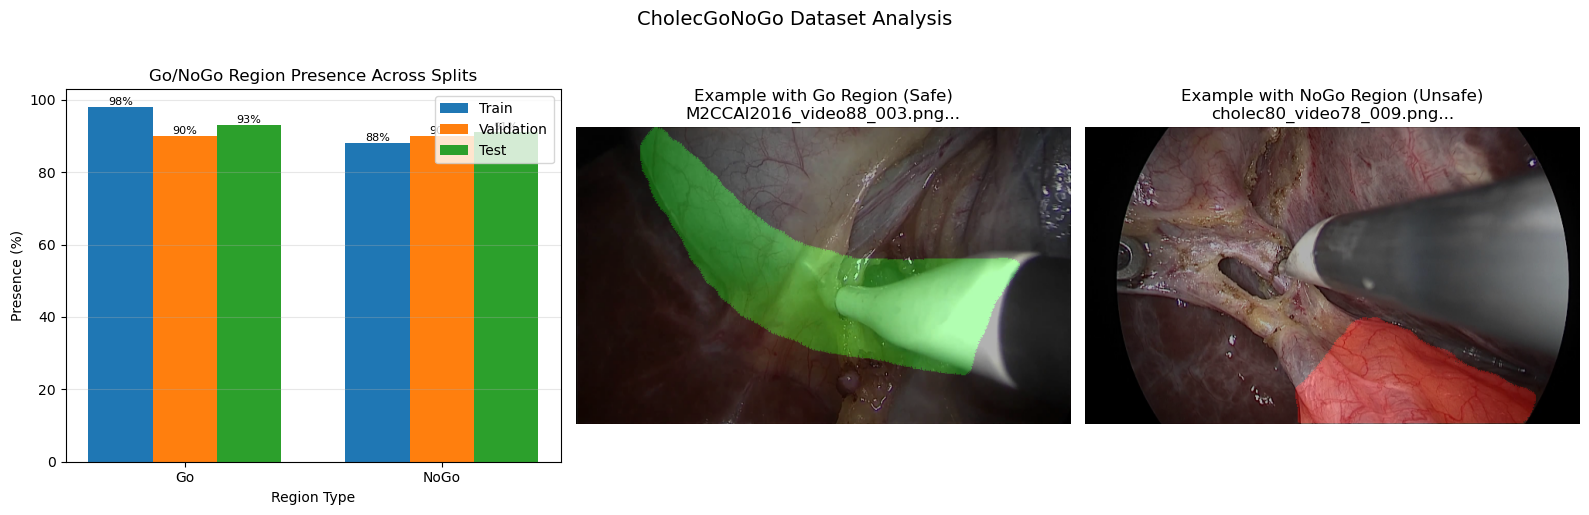

In [14]:
# Visualize Go/NoGo distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Region presence across splits
ax = axes[0]
region_names = [dataset.id2label[cid] for cid in dataset.label_ids]
x = np.arange(len(region_names))
width = 0.25

for i, split in enumerate(['train', 'validation', 'test']):
    counts = [split_stats[split][cid] for cid in dataset.label_ids]
    sample_size = min(100, dataset.total(split))
    percentages = [(c / sample_size) * 100 for c in counts]
    
    offset = (i - 1) * width
    bars = ax.bar(x + offset, percentages, width, label=split.capitalize())
    
    # Add value labels on bars
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.0f}%', ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Region Type')
ax.set_ylabel('Presence (%)')
ax.set_title('Go/NoGo Region Presence Across Splits')
ax.set_xticks(x)
ax.set_xticklabels(region_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 2: Example with Go regions
ax = axes[1]
# Find an example with Go regions
for idx in range(min(50, dataset.total('train'))):
    example = dataset.get_example('train', idx)
    img_t, lab_t = dataset.example_to_tensors(example)
    presence = dataset.labels_to_presence_vector(lab_t, min_pixels=50)
    
    if presence[0] == 1:  # Has Go region
        # Create overlay visualization
        image_np = np.array(example['image'])
        label_np = np.array(example['gonogo_label'])
        
        # Create semi-transparent overlay
        overlay = np.zeros_like(image_np)
        overlay[label_np == 1] = [0, 255, 0]     # Go - green
        
        # Blend with original image
        alpha = 0.3
        blended = (1 - alpha) * image_np + alpha * overlay
        blended = blended.astype(np.uint8)
        
        ax.imshow(blended)
        ax.set_title(f'Example with Go Region (Safe)\n{example["filename"][:30]}...')
        ax.axis('off')
        break

# Plot 3: Example with NoGo regions
ax = axes[2]
# Find an example with NoGo regions
for idx in range(min(50, dataset.total('train'))):
    example = dataset.get_example('train', idx)
    img_t, lab_t = dataset.example_to_tensors(example)
    presence = dataset.labels_to_presence_vector(lab_t, min_pixels=50)
    
    if presence[1] == 1:  # Has NoGo region
        # Create overlay visualization
        image_np = np.array(example['image'])
        label_np = np.array(example['gonogo_label'])
        
        # Create semi-transparent overlay
        overlay = np.zeros_like(image_np)
        overlay[label_np == 2] = [255, 0, 0]     # NoGo - red
        
        # Blend with original image
        alpha = 0.3
        blended = (1 - alpha) * image_np + alpha * overlay
        blended = blended.astype(np.uint8)
        
        ax.imshow(blended)
        ax.set_title(f'Example with NoGo Region (Unsafe)\n{example["filename"][:30]}...')
        ax.axis('off')
        break

plt.suptitle('CholecGoNoGo Dataset Analysis', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Sample Multiple Examples

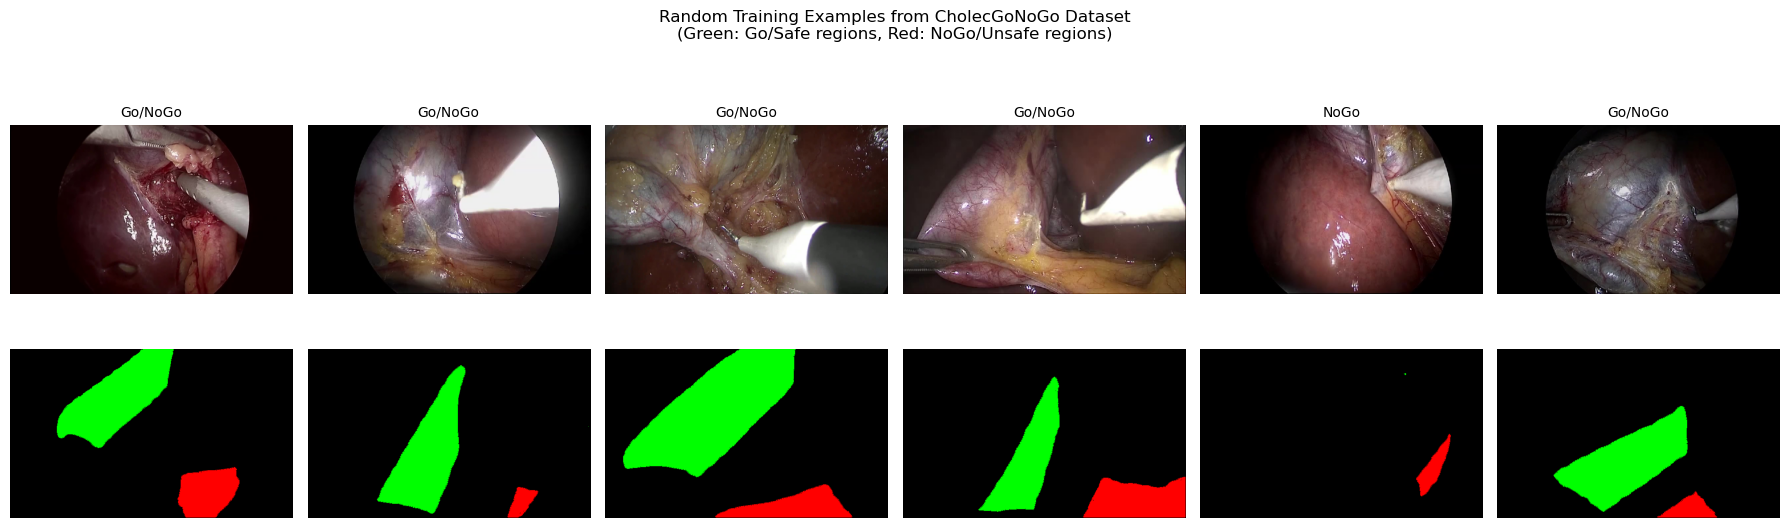

In [15]:
# Display multiple examples in a grid
n_examples = 6
fig, axes = plt.subplots(2, n_examples, figsize=(18, 6))

# Sample random indices
indices = np.random.choice(dataset.total('train'), n_examples, replace=False)

for col, idx in enumerate(indices):
    example = dataset.get_example('train', int(idx))
    img_t, lab_t = dataset.example_to_tensors(example)
    presence = dataset.labels_to_presence_vector(lab_t, min_pixels=50)
    
    # Top row: original images
    axes[0, col].imshow(example['image'])
    axes[0, col].axis('off')
    
    # Get present regions for title
    present_regions = []
    if presence[0] == 1:
        present_regions.append('Go')
    if presence[1] == 1:
        present_regions.append('NoGo')
    title = '/'.join(present_regions) if present_regions else 'Background'
    axes[0, col].set_title(title, fontsize=10)
    
    # Bottom row: segmentation
    label_np = np.array(example['gonogo_label'])
    colored_label = np.zeros((*label_np.shape, 3), dtype=np.uint8)
    colored_label[label_np == 1] = [0, 255, 0]     # Go - green
    colored_label[label_np == 2] = [255, 0, 0]     # NoGo - red
    
    axes[1, col].imshow(colored_label)
    axes[1, col].axis('off')

axes[0, 0].set_ylabel('Images', fontsize=12)
axes[1, 0].set_ylabel('Segmentation', fontsize=12)

plt.suptitle('Random Training Examples from CholecGoNoGo Dataset\n(Green: Go/Safe regions, Red: NoGo/Unsafe regions)', 
             fontsize=12)
plt.tight_layout()
plt.show()

## Visualize Go and NoGo Regions Together

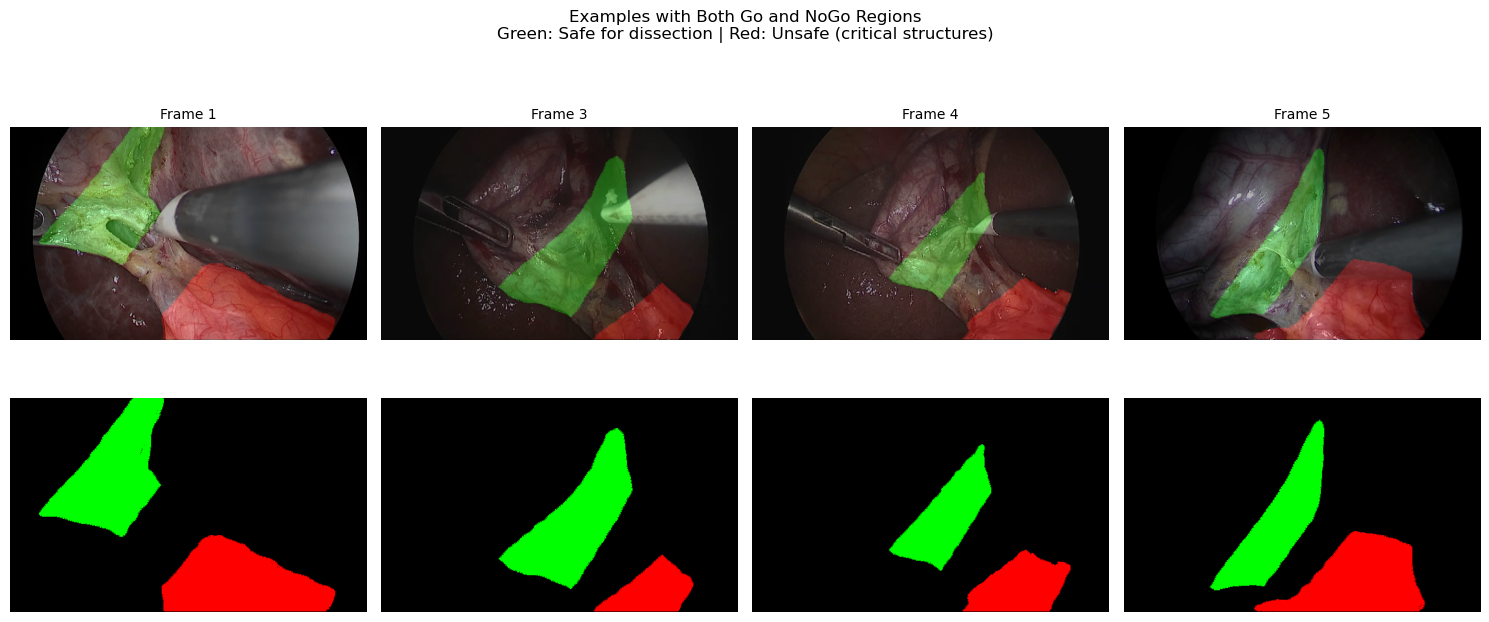

In [16]:
# Find examples with both Go and NoGo regions
examples_with_both = []

for idx in range(min(200, dataset.total('train'))):
    example = dataset.get_example('train', idx)
    img_t, lab_t = dataset.example_to_tensors(example)
    presence = dataset.labels_to_presence_vector(lab_t, min_pixels=50)
    
    if presence[0] == 1 and presence[1] == 1:  # Has both Go and NoGo
        examples_with_both.append(idx)
        if len(examples_with_both) >= 4:
            break

if examples_with_both:
    n_show = min(4, len(examples_with_both))
    fig, axes = plt.subplots(2, n_show, figsize=(15, 7))
    
    for col, idx in enumerate(examples_with_both[:n_show]):
        example = dataset.get_example('train', idx)
        
        # Top row: original image with overlay
        image_np = np.array(example['image'])
        label_np = np.array(example['gonogo_label'])
        
        overlay = np.zeros_like(image_np)
        overlay[label_np == 1] = [0, 255, 0]     # Go - green
        overlay[label_np == 2] = [255, 0, 0]     # NoGo - red
        
        alpha = 0.3
        blended = (1 - alpha) * image_np + alpha * overlay
        blended = blended.astype(np.uint8)
        
        axes[0, col].imshow(blended)
        axes[0, col].set_title(f'Frame {idx}', fontsize=10)
        axes[0, col].axis('off')
        
        # Bottom row: segmentation only
        colored_label = np.zeros((*label_np.shape, 3), dtype=np.uint8)
        colored_label[label_np == 1] = [0, 255, 0]     # Go
        colored_label[label_np == 2] = [255, 0, 0]     # NoGo
        
        axes[1, col].imshow(colored_label)
        axes[1, col].axis('off')
        
        # Calculate areas
        go_area = (label_np == 1).sum()
        nogo_area = (label_np == 2).sum()
        axes[1, col].set_xlabel(f'Go: {go_area:,} px\nNoGo: {nogo_area:,} px', fontsize=9)
    
    axes[0, 0].set_ylabel('Blended', fontsize=12)
    axes[1, 0].set_ylabel('Segmentation', fontsize=12)
    
    plt.suptitle('Examples with Both Go and NoGo Regions\n' +
                 'Green: Safe for dissection | Red: Unsafe (critical structures)', 
                 fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No examples found with both Go and NoGo regions in the sample.")